In [43]:
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.layout import kamada_kawai_layout
from itertools import combinations
import numpy as np
import seaborn as sns
from scipy.spatial import distance

In [45]:
def extract_node_positions(graph):
    """Extracts node positions (x, y) from GraphML or computes them."""
    x_pos = nx.get_node_attributes(graph, "x_pos")
    y_pos = nx.get_node_attributes(graph, "y_pos")

    if not x_pos or not y_pos:  # If positions are missing, compute them
        pos = nx.kamada_kawai_layout(graph)
        for node, (x, y) in pos.items():
            graph.nodes[node]["x_pos"] = x
            graph.nodes[node]["y_pos"] = y
    else:
        pos = {node: (float(x_pos[node]), float(y_pos[node])) for node in graph.nodes() if node in x_pos and node in y_pos}

    return pos

def count_edge_crossings(graph):
    """Counts the number of edge crossings based on node positions."""
    crossings = 0
    pos = extract_node_positions(graph)  # Ensure positions are available
    edges = list(graph.edges())

    for (u1, v1), (u2, v2) in combinations(edges, 2):
        if len({u1, v1, u2, v2}) < 4:
            continue  # They share a node, so they cannot cross

        x1, y1 = pos[u1]
        x2, y2 = pos[v1]
        x3, y3 = pos[u2]
        x4, y4 = pos[v2]

        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

        if (ccw((x1, y1), (x3, y3), (x4, y4)) != ccw((x2, y2), (x3, y3), (x4, y4))) and \
           (ccw((x1, y1), (x2, y2), (x3, y3)) != ccw((x1, y1), (x2, y2), (x4, y4))):
            crossings += 1

    return crossings

def compute_cmax(graph):
    """Computes the theoretical maximum number of crossings c_max."""
    E = graph.number_of_edges()
    degree_dict = dict(graph.degree())

    sum_dg = sum(degree_dict[node] * (degree_dict[node] - 1) for node in graph.nodes())

    c_max = (E * (E - 1)) / 2 - 0.5 * sum_dg
    return max(c_max, 1)  # Avoid division by zero

def compute_crosslessness(graph):
    """Computes crosslessness metric using c_max formula."""
    edge_crossings = count_edge_crossings(graph)
    c_max = compute_cmax(graph)
    return 1 - (edge_crossings / c_max)

def compute_node_occlusion(graph, threshold=0.05):
    """Counts the number of occluded nodes (nodes too close to each other)."""
    pos = extract_node_positions(graph)
    nodes = list(graph.nodes())
    occluded_count = 0

    for u, v in combinations(nodes, 2):
        if distance.euclidean(pos[u], pos[v]) < threshold:
            occluded_count += 1

    return occluded_count

def compute_node_edge_resolution(graph):
    """Computes the minimum Euclidean distance between any node and an edge it is not incident to."""
    pos = extract_node_positions(graph)
    min_distance = float("inf")

    for node in graph.nodes():
        x0, y0 = pos[node]
        for u, v in graph.edges():
            if node in {u, v}:  
                continue
            
            x1, y1 = pos[u]
            x2, y2 = pos[v]

            edge_vec = np.array([x2 - x1, y2 - y1])
            node_vec = np.array([x0 - x1, y0 - y1])
            edge_length = np.linalg.norm(edge_vec)

            if edge_length == 0:
                continue  

            t = np.dot(node_vec, edge_vec) / edge_length**2
            t = max(0, min(1, t))  

            closest_point = np.array([x1, y1]) + t * edge_vec
            distance_to_edge = np.linalg.norm(np.array([x0, y0]) - closest_point)

            min_distance = min(min_distance, distance_to_edge)

    return min_distance if min_distance != float("inf") else -1

def analyze_graph(graph):
    """Compute graph statistics and edge crossings."""
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    avg_degree = sum(dict(graph.degree()).values()) / num_nodes if num_nodes > 0 else 0
    density = nx.density(graph)
    diameter = nx.diameter(graph) if nx.is_connected(graph) else -1
    avg_shortest_path = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else -1
    num_components = nx.number_connected_components(graph)
    assortativity = nx.degree_assortativity_coefficient(graph)
    edge_crossings = count_edge_crossings(graph)
    crosslessness = compute_crosslessness(graph)
    node_occlusion = compute_node_occlusion(graph)
    node_edge_resolution = compute_node_edge_resolution(graph)

    return {
        "Nodes": num_nodes,
        "Edges": num_edges,
        "Avg Degree": avg_degree,
        "Density": density,
        "Diameter": diameter,
        "Avg Shortest Path": avg_shortest_path,
        "Num Components": num_components,
        "Assortativity": assortativity,
        "Edge Crossings": edge_crossings,
        "Crosslessness": crosslessness,
        "Node Occlusion": node_occlusion,
        "Node-Edge Resolution": node_edge_resolution
    }

def process_graphml_folder(folder_path, output_folder):
    """Processes all .graphml files, updates node attributes, and saves them."""
    graph_stats = []

    for file in os.listdir(folder_path):
        if file.endswith(".graphml"):
            file_path = os.path.join(folder_path, file)
            try:
                graph = nx.read_graphml(file_path)

                degree = dict(graph.degree())
                clustering = nx.clustering(graph)
                betweenness = nx.betweenness_centrality(graph)
                eigenvector = nx.eigenvector_centrality(graph, max_iter=1000, tol=1e-6)
                pagerank = nx.pagerank(graph)

                stats = analyze_graph(graph)
                graph.graph["edge_crossings"] = stats["Edge Crossings"]
                graph.graph["crosslessness"] = stats["Crosslessness"]
                graph.graph["node_occlusion"] = stats["Node Occlusion"]
                graph.graph["node_edge_resolution"] = stats["Node-Edge Resolution"]

                for node in graph.nodes():
                    graph.nodes[node]["degree"] = degree[node]
                    graph.nodes[node]["clustering"] = clustering[node]
                    graph.nodes[node]["betweenness"] = betweenness[node]
                    graph.nodes[node]["eigenvector"] = eigenvector[node]
                    graph.nodes[node]["pagerank"] = pagerank[node]

                graph_stats.append(stats)

                output_file_path = os.path.join(output_folder, file)
                nx.write_graphml(graph, output_file_path)

            except Exception as e:
                print(f"❌ Error processing {file}: {e}")

    return pd.DataFrame(graph_stats)

# Rome Graphs 1
subset of 468+- rome graphs


In [48]:
current_folder = os.getcwd() 
folder_path = os.path.join(current_folder, "rome1") 
folder_path_out = os.path.join(current_folder, "rome1_processed") 

df = process_graphml_folder(folder_path, folder_path_out)
df.tail()

,Nodes,Edges,Avg Degree,Density,Diameter,Avg Shortest Path,Num Components,Assortativity,Edge Crossings,Crosslessness,Node Occlusion,Node-Edge Resolution
464,18,17,1.888889,0.111111,11,4.666667,1,-0.582996,0,1.000000,0,0.170253
465,11,13,2.363636,0.236364,4,2.345455,1,-0.181818,1,0.982759,0,0.170927
466,11,12,2.181818,0.218182,6,2.618182,1,-0.363636,1,0.980000,0,0.146496
467,16,15,1.875000,0.125000,9,3.908333,1,-0.469595,0,1.000000,0,0.217757
468,13,13,2.000000,0.166667,8,3.628205,1,0.057971,0,1.000000,0,0.241746


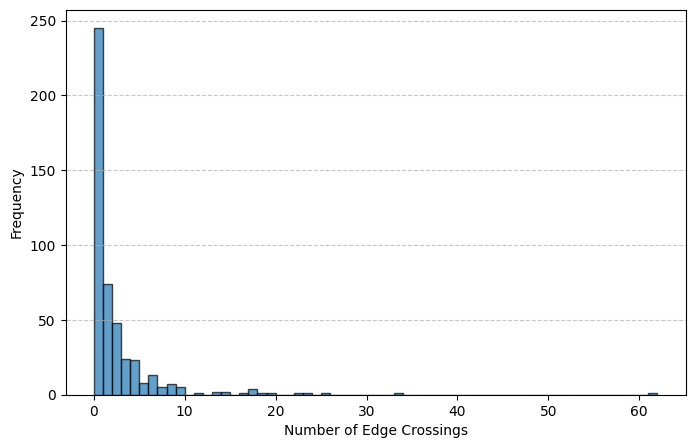

In [49]:
plt.figure(figsize=(8, 5))
plt.hist(df["Edge Crossings"], bins=range(min(df["Edge Crossings"]), max(df["Edge Crossings"]) + 2), edgecolor='black', alpha=0.7)
plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

In [50]:
nodes_stats = (df["Nodes"].mean(), df["Nodes"].min(), df["Nodes"].max())
edges_stats = (df["Edges"].mean(), df["Edges"].min(), df["Edges"].max())
croslessness_stats = (df["Crosslessness"].mean(), df["Crosslessness"].min(), df["Crosslessness"].max())
node_occlusion_stats = (df["Node Occlusion"].mean(), df["Node Occlusion"].min(), df["Node Occlusion"].max())
print(nodes_stats)
print(edges_stats)
print(croslessness_stats)
print(node_occlusion_stats)

(18.04904051172708, 10, 83)
(21.078891257995735, 9, 110)
(0.9933550048310018, 0.9478260869565217, 1.0)
(0.008528784648187633, 0, 3)


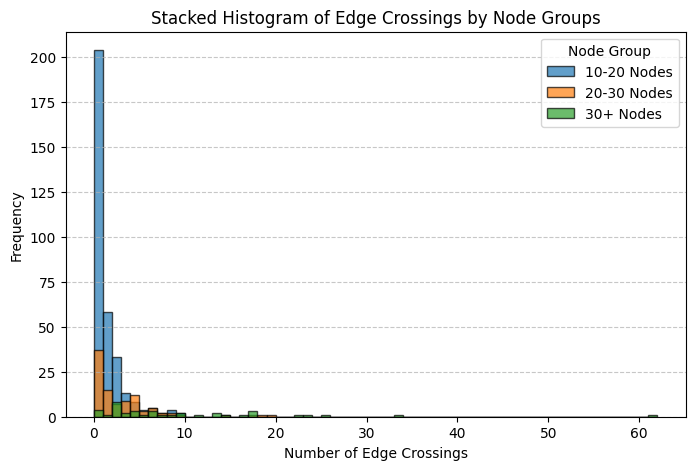

In [51]:

bins = [0, 10, 20, 30, float('inf')]
labels = ["0-10 Nodes", "10-20 Nodes", "20-30 Nodes", "30+ Nodes"]
df["Node Group"] = pd.cut(df["Nodes"], bins=bins, labels=labels, right=False)
plt.figure(figsize=(8, 5))
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"] 
node_groups = df["Node Group"].unique()
for i, group in enumerate(node_groups):
    subset = df[df["Node Group"] == group]["Edge Crossings"]
    plt.hist(subset, bins=range(min(df["Edge Crossings"]), max(df["Edge Crossings"]) + 2),
             edgecolor='black', alpha=0.7, label=group, color=custom_colors[i], stacked=True)
plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.title("Stacked Histogram of Edge Crossings by Node Groups")
plt.legend(title="Node Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()




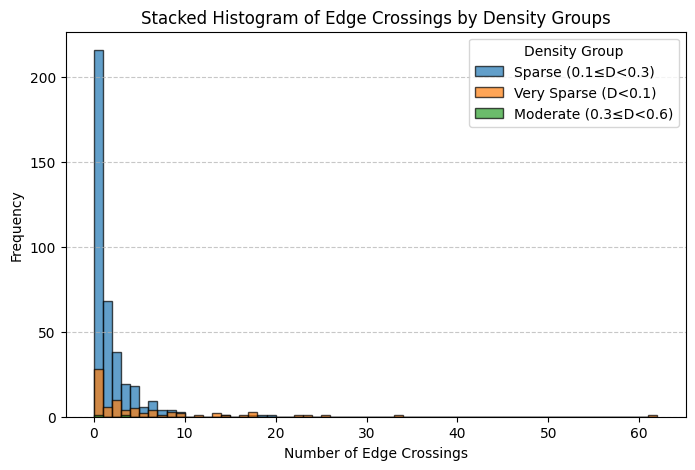

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already loaded and contains 'Nodes', 'Density', and 'Edge Crossings' columns

# Define bins and labels for density-based grouping
bins = [0, 0.1, 0.3, 0.6, float('inf')]
labels = ["Very Sparse (D<0.1)", "Sparse (0.1≤D<0.3)", "Moderate (0.3≤D<0.6)", "Dense (D≥0.6)"]

# Create a new column for density-based groups
df["Density Group"] = pd.cut(df["Density"], bins=bins, labels=labels, right=False)

# Plot histogram with stacked bars
plt.figure(figsize=(8, 5))
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Custom colors for groups

density_groups = df["Density Group"].unique()
for i, group in enumerate(density_groups):
    subset = df[df["Density Group"] == group]["Edge Crossings"]
    plt.hist(subset, bins=range(min(df["Edge Crossings"]), max(df["Edge Crossings"]) + 2),
             edgecolor='black', alpha=0.7, label=group, color=custom_colors[i], stacked=True)

plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.title("Stacked Histogram of Edge Crossings by Density Groups")
plt.legend(title="Density Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


# Rome Graphs


In [54]:
current_folder = os.getcwd() 
folder_path = os.path.join(current_folder, "rome") 
folder_path_out = os.path.join(current_folder, "rome_processed") 
df = process_graphml_folder(folder_path,folder_path_out)
df.tail()

❌ Error processing grafo6754.50.graphml: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 1000 iterations')
❌ Error processing grafo9653.71.graphml: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 1000 iterations')


,Nodes,Edges,Avg Degree,Density,Diameter,Avg Shortest Path,Num Components,Assortativity,Edge Crossings,Crosslessness,Node Occlusion,Node-Edge Resolution
11527,94,137,2.914894,0.031343,11,4.417296,1,-0.085089,168,0.981223,5,0.000110
11528,32,37,2.312500,0.074597,10,4.058468,1,-0.067886,7,0.988156,0,0.032766
11529,40,50,2.500000,0.064103,8,3.916667,1,-0.033940,15,0.986679,0,0.006104
11530,38,47,2.473684,0.066856,8,4.159317,1,-0.267986,5,0.994919,0,0.001350
11531,39,49,2.512821,0.066127,8,3.875843,1,-0.413645,13,0.987850,0,0.017034


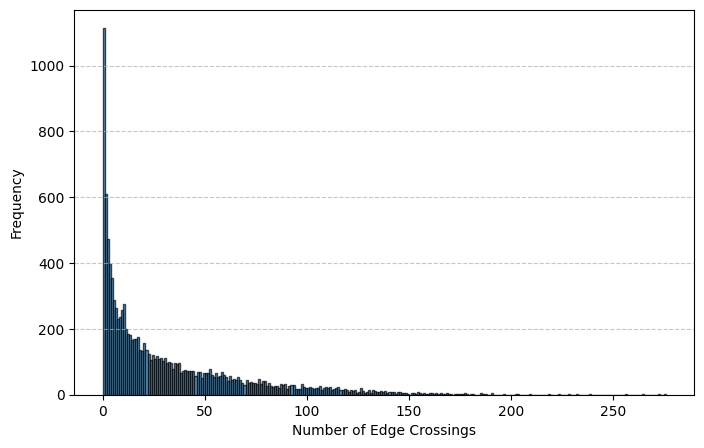

In [55]:
plt.figure(figsize=(8, 5))
plt.hist(df["Edge Crossings"], bins=range(min(df["Edge Crossings"]), max(df["Edge Crossings"]) + 2), edgecolor='black', alpha=0.7)
plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

In [56]:
nodes_stats = (df["Nodes"].mean(), df["Nodes"].min(), df["Nodes"].max())
edges_stats = (df["Edges"].mean(), df["Edges"].min(), df["Edges"].max())
print(nodes_stats)
print(edges_stats)

(52.33870967741935, 10, 110)
(69.05731876517517, 9, 158)


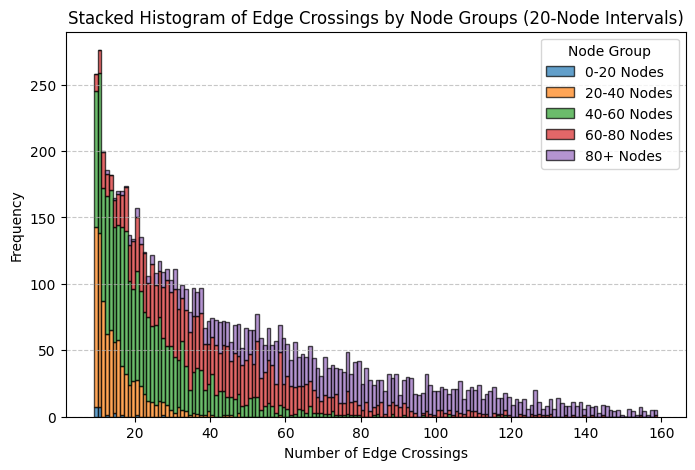

In [57]:
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ["0-20 Nodes", "20-40 Nodes", "40-60 Nodes", "60-80 Nodes", "80+ Nodes"]

df["Node Group"] = pd.cut(df["Nodes"], bins=bins, labels=labels, right=False)

# Create the histogram
plt.figure(figsize=(8, 5))
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

# Ensure correct order of groups
node_groups = sorted(df["Node Group"].dropna().unique())

# Collect data for stacking
hist_data = [df[df["Node Group"] == group]["Edge Crossings"] for group in node_groups]

# Use plt.hist() to create a stacked histogram
plt.hist(hist_data, bins=range(min(df["Edges"]), max(df["Edges"]) + 2),
         edgecolor='black', alpha=0.7, label=node_groups, color=custom_colors[:len(node_groups)], stacked=True)

plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.title("Stacked Histogram of Edge Crossings by Node Groups (20-Node Intervals)")
plt.legend(title="Node Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Rome_2 Graphs

In [59]:

output_folder = os.path.join(current_folder, "rome2_processed")

# Dictionary to track counts of graphs per edge crossing number
edge_crossing_counts = {}
selected_files = []

for file in os.listdir(output_folder):
    if file.endswith(".graphml"):
        file_path = os.path.join(output_folder, file)
        try:
            # Read graph to determine edge crossings
            graph = nx.read_graphml(file_path)
            edge_crossings = int(graph.graph.get("edge_crossings", 0))

         
            if edge_crossing_counts.get(edge_crossings, 0) < 175:
                edge_crossing_counts[edge_crossings] = edge_crossing_counts.get(edge_crossings, 0) + 1
                selected_files.append(file)
        except Exception as e:
            print(f"Error processing {file}: {e}")

# Remove excess files
for file in os.listdir(output_folder):
    if file.endswith(".graphml") and file not in selected_files:
        os.remove(os.path.join(output_folder, file))  # Remove excess files

print(f"Processed {len(selected_files)} graphs into {output_folder} with a max of 20 per edge crossing count.")

Processed 8912 graphs into C:\Users\lucas\Desktop\thesis\code\ThesisLucasdelArco\Data\rome2_processed with a max of 20 per edge crossing count.


In [60]:
df.tail()

,Nodes,Edges,Avg Degree,Density,Diameter,Avg Shortest Path,Num Components,Assortativity,Edge Crossings,Crosslessness,Node Occlusion,Node-Edge Resolution,Node Group
11527,94,137,2.914894,0.031343,11,4.417296,1,-0.085089,168,0.981223,5,0.000110,80+ Nodes
11528,32,37,2.312500,0.074597,10,4.058468,1,-0.067886,7,0.988156,0,0.032766,20-40 Nodes
11529,40,50,2.500000,0.064103,8,3.916667,1,-0.033940,15,0.986679,0,0.006104,40-60 Nodes
11530,38,47,2.473684,0.066856,8,4.159317,1,-0.267986,5,0.994919,0,0.001350,20-40 Nodes
11531,39,49,2.512821,0.066127,8,3.875843,1,-0.413645,13,0.987850,0,0.017034,20-40 Nodes


In [61]:
# Define the folder containing GraphML files
graphml_folder = output_folder

# List all GraphML files in the folder
graphml_files = [f for f in os.listdir(output_folder) if f.endswith(".graphml")]

# Initialize list to store graph statistics
graph_stats = []

# Process each GraphML file
for file in graphml_files:
    file_path = os.path.join(output_folder, file)
    try:
        # Load the graph
        graph = nx.read_graphml(file_path)

        # Compute graph statistics
        num_nodes = graph.number_of_nodes()
        num_edges = graph.number_of_edges()
        avg_degree = sum(dict(graph.degree()).values()) / num_nodes if num_nodes > 0 else 0
        density = nx.density(graph)
        diameter = nx.diameter(graph) if nx.is_connected(graph) else -1  # -1 for disconnected graphs
        avg_shortest_path = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else -1
        num_components = nx.number_connected_components(graph)
        assortativity = nx.degree_assortativity_coefficient(graph)

        # Get edge crossings from the graph metadata (assuming it exists in GraphML)
        edge_crossings = int(graph.graph.get("edge_crossings", 0))

        # Store results
        graph_stats.append([file, num_nodes, num_edges, avg_degree, density, diameter, avg_shortest_path,
                            num_components, assortativity, edge_crossings])

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert results to a DataFrame
columns = ["Graph ID", "Nodes", "Edges", "Avg Degree", "Density", "Diameter", 
           "Avg Shortest Path", "Num Components", "Assortativity", "Edge Crossings"]
df = pd.DataFrame(graph_stats, columns=columns)

df

,Graph ID,Nodes,Edges,Avg Degree,Density,Diameter,Avg Shortest Path,Num Components,Assortativity,Edge Crossings
0,grafo1000.14.graphml,14,20,2.857143,0.219780,4,2.186813,1,-0.225316,4
1,grafo10000.38.graphml,38,52,2.736842,0.073969,11,4.223329,1,0.044803,14
2,grafo10001.32.graphml,32,32,2.000000,0.064516,12,5.620968,1,-0.185185,0
3,grafo10002.40.graphml,40,45,2.250000,0.057692,11,4.716667,1,-0.082405,4
4,grafo10003.40.graphml,40,50,2.500000,0.064103,10,3.885897,1,-0.291080,12
...,...,...,...,...,...,...,...,...,...,...
8907,grafo9987.91.graphml,91,118,2.593407,0.028816,10,4.799512,1,-0.134872,66
8908,grafo9993.91.graphml,91,128,2.813187,0.031258,10,4.533333,1,-0.104561,115
8909,grafo9994.91.graphml,91,121,2.659341,0.029548,15,5.320391,1,-0.084318,63
8910,grafo9995.94.graphml,94,137,2.914894,0.031343,11,4.417296,1,-0.085089,168


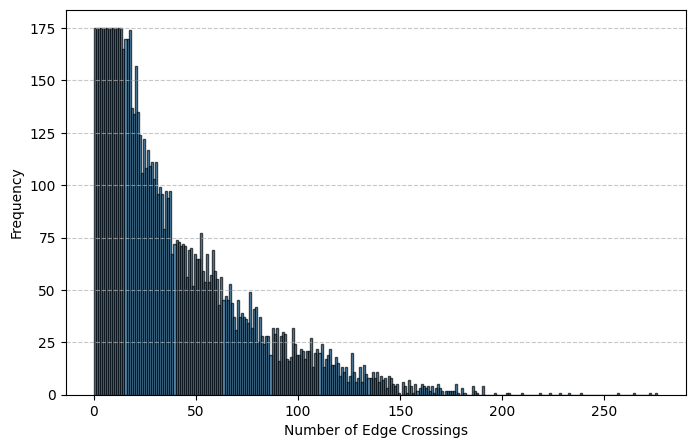

In [62]:
plt.figure(figsize=(8, 5))
plt.hist(df["Edge Crossings"], bins=range(min(df["Edge Crossings"]), max(df["Edge Crossings"]) + 2), edgecolor='black', alpha=0.7)
plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

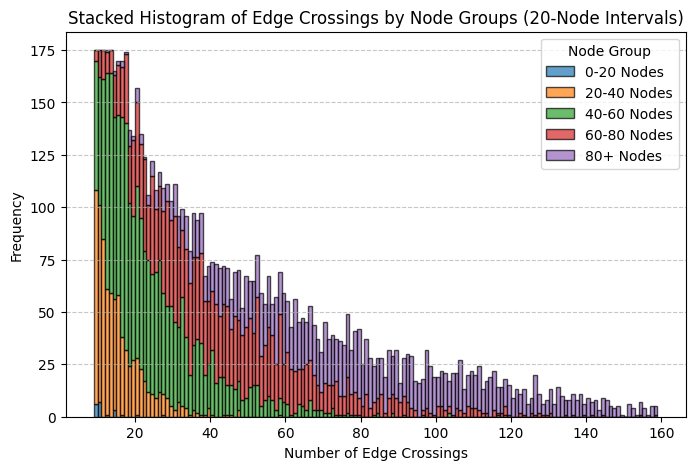

In [63]:
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ["0-20 Nodes", "20-40 Nodes", "40-60 Nodes", "60-80 Nodes", "80+ Nodes"]

df["Node Group"] = pd.cut(df["Nodes"], bins=bins, labels=labels, right=False)

# Create the histogram
plt.figure(figsize=(8, 5))
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

# Ensure correct order of groups
node_groups = sorted(df["Node Group"].dropna().unique())

# Collect data for stacking
hist_data = [df[df["Node Group"] == group]["Edge Crossings"] for group in node_groups]

# Use plt.hist() to create a stacked histogram
plt.hist(hist_data, bins=range(min(df["Edges"]), max(df["Edges"]) + 2),
         edgecolor='black', alpha=0.7, label=node_groups, color=custom_colors[:len(node_groups)], stacked=True)

plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.title("Stacked Histogram of Edge Crossings by Node Groups (20-Node Intervals)")
plt.legend(title="Node Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [64]:
nodes_stats = (df["Nodes"].mean(), df["Nodes"].min(), df["Nodes"].max())
edges_stats = (df["Edges"].mean(), df["Edges"].min(), df["Edges"].max())
print(nodes_stats)
print(edges_stats)

(59.70421903052065, 10, 110)
(79.91404847396768, 9, 158)
